In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
import calendar


from datetime import datetime
from scipy import stats
import researchpy as rp
from scipy.stats import levene
from sklearn.preprocessing import MinMaxScaler
import math

warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

plt.rcParams["figure.figsize"] = (10,8)

Hacemos un EDA de cada df

In [2]:
df = pd.read_csv('../data/01_bikes_casuales.csv', index_col = 0 )
df.head(2)

,fecha,estacion,año,mes,vacaciones,dia_semana,laborable,clima,temperatura,sensacion_termica,humedad,viento,casuales
0,2018-01-01,winter,0,1,1,1,NO,2,14.110847,18.18125,80.5833,10.749882,331
1,2018-01-02,winter,0,1,0,2,SI,2,14.902598,17.68695,69.6087,16.652113,131


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fecha              730 non-null    object 
 1   estacion           730 non-null    object 
 2   año                730 non-null    int64  
 3   mes                730 non-null    int64  
 4   vacaciones         730 non-null    int64  
 5   dia_semana         730 non-null    int64  
 6   laborable          730 non-null    object 
 7   clima              730 non-null    int64  
 8   temperatura        730 non-null    float64
 9   sensacion_termica  730 non-null    float64
 10  humedad            730 non-null    float64
 11  viento             730 non-null    float64
 12  casuales           730 non-null    int64  
dtypes: float64(4), int64(6), object(3)
memory usage: 79.8+ KB


In [4]:
df.shape

(730, 13)

In [5]:
df.duplicated().sum()

0

In [6]:
df.isnull().sum()

fecha                0
estacion             0
año                  0
mes                  0
vacaciones           0
dia_semana           0
laborable            0
clima                0
temperatura          0
sensacion_termica    0
humedad              0
viento               0
casuales             0
dtype: int64

In [7]:
df["vacaciones"] = df["vacaciones"].astype("category")

In [8]:
def detectar_outliers(lista_columnas, dataframe):
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        # calculamos los límites
        outlier_step = 1.5 * IQR
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila.
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
    return dicc_indices

In [9]:
numericas = df.select_dtypes(include = np.number).drop(['año', 'mes', 'dia_semana'], axis =1)
columnas = numericas.columns

In [10]:
indices = detectar_outliers(columnas, numericas)

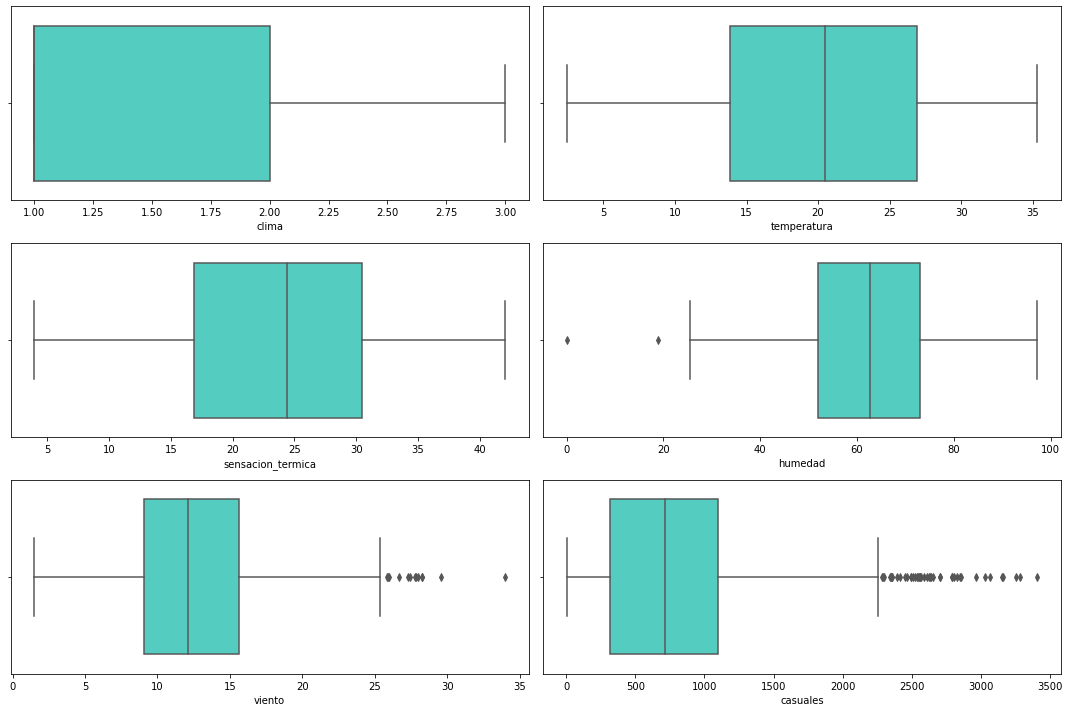

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(15,10))

axes = axes.flat

for indice, columna in enumerate(numericas.columns):
    sns.boxplot(x = numericas[columna], data = df, ax=axes[indice], color = "turquoise"); # para trazar una línea de densidad

    
plt.tight_layout()
plt.show()


Seria interesante ver que que tienen en común los días en los que los casuales alquilan muchas más bicis

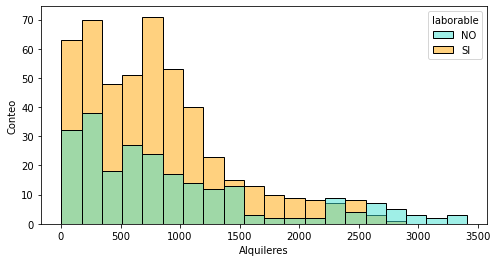

In [12]:
plt.figure(figsize =(8,4))

fig = sns.histplot(x='casuales', data = df, hue = 'laborable', palette=sns.blend_palette(['turquoise','orange'],2))

# establecemos el nombre de los ejes, pero recordad que esto no es obligatorio ya que Seaborn nos los genera automaticamente
fig.set(ylabel='Conteo', xlabel = 'Alquileres')

# Ponemos título a  la gráfica
fig.set_title('')

# mostramos la gráfica
plt.show()


En esta gráfica observamos que los dias en los que mas bicis se alquilan son dias no laborables. (La cola está sesgada hacia la derecha)

In [13]:
df_enero = df[(df['mes']== 5)&(df['año']== 1)]

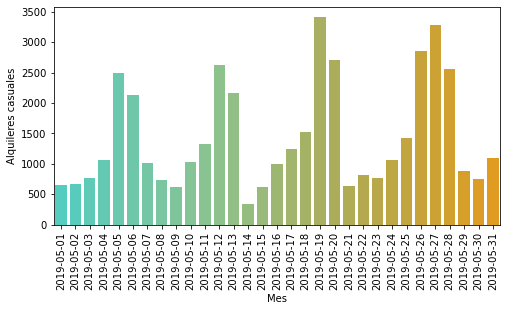

In [14]:
plt.figure(figsize =(8,4))

fig = sns.barplot(x='fecha', y = 'casuales', data = df_enero, palette=sns.blend_palette(['turquoise','orange'],31) )

# establecemos el nombre de los ejes, pero recordad que esto no es obligatorio ya que Seaborn nos los genera automaticamente
fig.set(ylabel='Alquileres casuales', xlabel = 'Mes')

# Ponemos título a  la gráfica
fig.set_title('')

# mostramos la gráfica
plt.xticks(rotation= 90)
plt.show()

Vemos que no hay una relación entre los alquileres a principio o final de mes

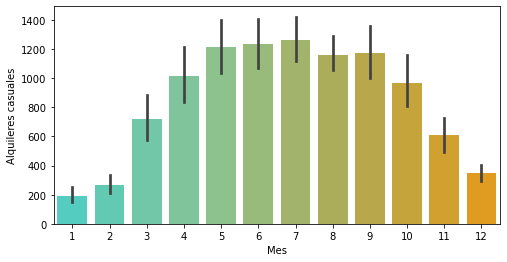

In [15]:
plt.figure(figsize =(8,4))

fig = sns.barplot(x='mes', y = 'casuales', data = df, palette=sns.blend_palette(['turquoise','orange'],12) )

# establecemos el nombre de los ejes, pero recordad que esto no es obligatorio ya que Seaborn nos los genera automaticamente
fig.set(ylabel='Alquileres casuales', xlabel = 'Mes')

# Ponemos título a  la gráfica
fig.set_title('')

# mostramos la gráfica
plt.show()

<AxesSubplot:xlabel='mes', ylabel='casuales'>

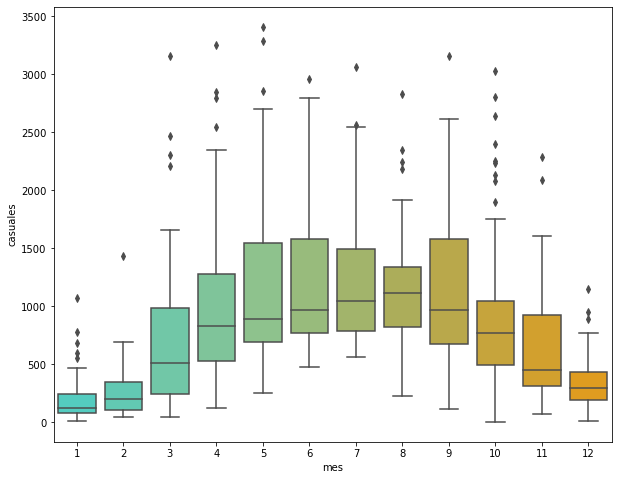

In [16]:
sns.boxplot(data=df, y= "casuales", x = "mes", palette=sns.blend_palette(['turquoise','orange'],12))

baja importancia a alta meses
1-2-12 = 0

5-6-7-9 = 

8-10 = 1

3-4-11 =  


---

## Miramos las asunciones

---

### Testeamos la normalidad de la var respuesta

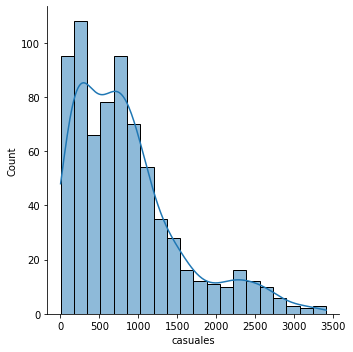

In [17]:
sns.displot(df["casuales"], kde=True)

In [18]:
stats.shapiro(df["casuales"])

ShapiroResult(statistic=0.8850967288017273, pvalue=7.660028716313278e-23)

Los datos no son normales porque son menores de 0.05

### Procedemos a normalizar la variable respuesta

Raiz cuadrada

In [19]:
df["casuales_raiz"] = df["casuales"].apply(lambda x: math.sqrt(x))

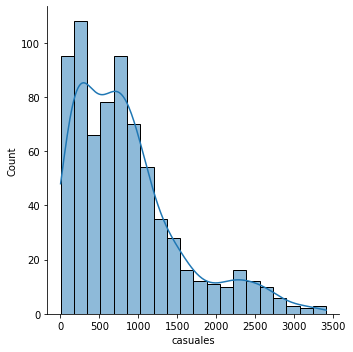

In [20]:
sns.displot(df["casuales"], kde=True)

In [21]:
stats.shapiro(df["casuales_raiz"])

ShapiroResult(statistic=0.9811134338378906, pvalue=4.261200459154679e-08)

Observamos que nuestro p_valor > 0.05 nuestros datos NO son normales. 

Box_cox

In [22]:
df['casuales_box'], lambda_ajustada = stats.boxcox(df['casuales'])


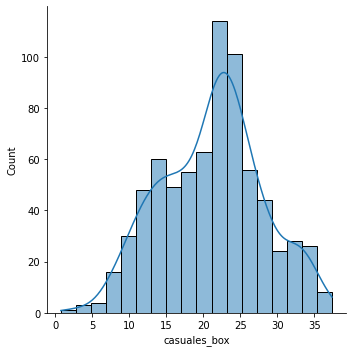

In [23]:
sns.displot(df["casuales_box"], kde=True)

In [24]:
stats.shapiro(df["casuales_box"])

ShapiroResult(statistic=0.9915913939476013, pvalue=0.000365116517059505)

Observamos que nuestro p_valor > 0.05 nuestros datos NO son normales. 

In [25]:
df["casuales_log"] = df["casuales"].apply(lambda x: np.log(x) if x > 0 else 0)

In [26]:
stats.shapiro(df["casuales_log"])

ShapiroResult(statistic=0.9472163915634155, pvalue=1.8073885266976222e-15)

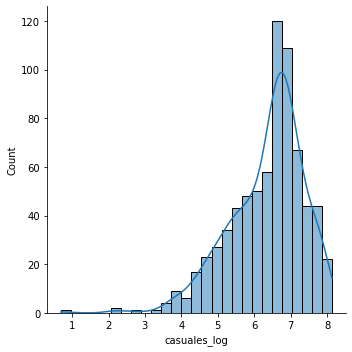

In [27]:
sns.displot(df["casuales_log"], kde=True)

Observamos que nuestro p_valor > 0.05 nuestros datos NO son normales. 

Min Scaler

In [28]:
minmax = MinMaxScaler()
minmax.fit(df[['casuales']])

MinMaxScaler()

In [29]:
X_normalizadas = minmax.transform(df[['casuales']])

In [30]:
X_normalizadas.min(axis=0)

array([0.])

In [31]:
X_normalizadas.max(axis=0)

array([1.])

In [32]:
numericas_minmax= pd.DataFrame(X_normalizadas, columns= ['casuales'])

In [33]:
df['casuales_min_max'] = numericas_minmax

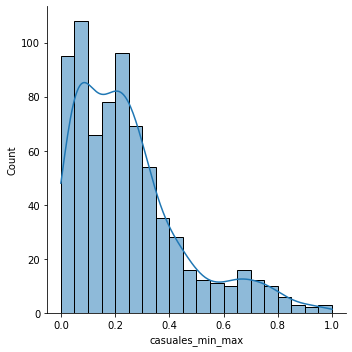

In [34]:
sns.displot(df["casuales_min_max"], kde=True)

In [35]:
stats.shapiro(df["casuales_min_max"])

ShapiroResult(statistic=0.8850969076156616, pvalue=7.660317123860226e-23)


Observamos que nuestro p_valor > 0.05 nuestros datos NO son normales. 

### No conseguimos normalizar la variable respuesta con ningún método así que pasamos a tratar los datos para hacer el método mediante decision tree

In [36]:
#Borramos las columnas que no necesitamos 
df.drop(['casuales_raiz','casuales_box', 'casuales_log', 'casuales_min_max'], axis=1, inplace=True )

In [37]:
df.head(2)

,fecha,estacion,año,mes,vacaciones,dia_semana,laborable,clima,temperatura,sensacion_termica,humedad,viento,casuales
0,2018-01-01,winter,0,1,1,1,NO,2,14.110847,18.18125,80.5833,10.749882,331
1,2018-01-02,winter,0,1,0,2,SI,2,14.902598,17.68695,69.6087,16.652113,131


---

### Análisis de correlación 

---

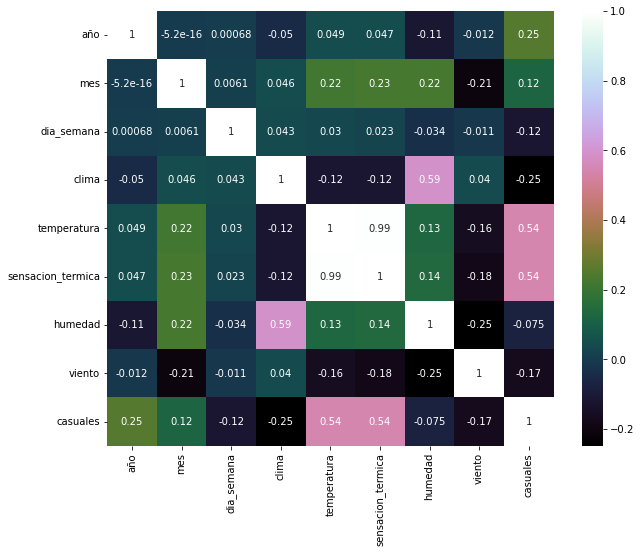

In [38]:
sns.heatmap(df.corr(), 
            cmap = "cubehelix", 
           annot = True
           );

In [39]:
df.corr()

,año,mes,dia_semana,clima,temperatura,sensacion_termica,humedad,viento,casuales
año,1.000000e+00,-5.162656e-16,0.000684,-0.050322,0.048789,0.047215,-0.112547,-0.011624,0.250502
mes,-5.162656e-16,1.000000e+00,0.006080,0.045613,0.219083,0.226430,0.224937,-0.208013,0.121208
dia_semana,6.843499e-04,6.079650e-03,1.000000,0.042703,0.029929,0.023235,-0.034223,-0.011361,-0.120906
clima,-5.032247e-02,4.561335e-02,0.042703,1.000000,-0.119503,-0.120559,0.590277,0.039769,-0.246044
temperatura,4.878919e-02,2.190833e-01,0.029929,-0.119503,1.000000,0.991696,0.128565,-0.158186,0.542731
sensacion_termica,4.721519e-02,2.264302e-01,0.023235,-0.120559,0.991696,1.000000,0.141512,-0.183876,0.543362
humedad,-1.125471e-01,2.249368e-01,-0.034223,0.590277,0.128565,0.141512,1.000000,-0.248506,-0.075211
viento,-1.162435e-02,-2.080131e-01,-0.011361,0.039769,-0.158186,-0.183876,-0.248506,1.000000,-0.167995
casuales,2.505017e-01,1.212079e-01,-0.120906,-0.246044,0.542731,0.543362,-0.075211,-0.167995,1.000000


Observamos que temperatura y sensación térmica correlacionan de manera casi total, por lo tanto lo consideramos información redundante y decidimos eliminar una. Vemos más decimales con el df para valorar y vemos que sensacion térmica correlaciona mas.


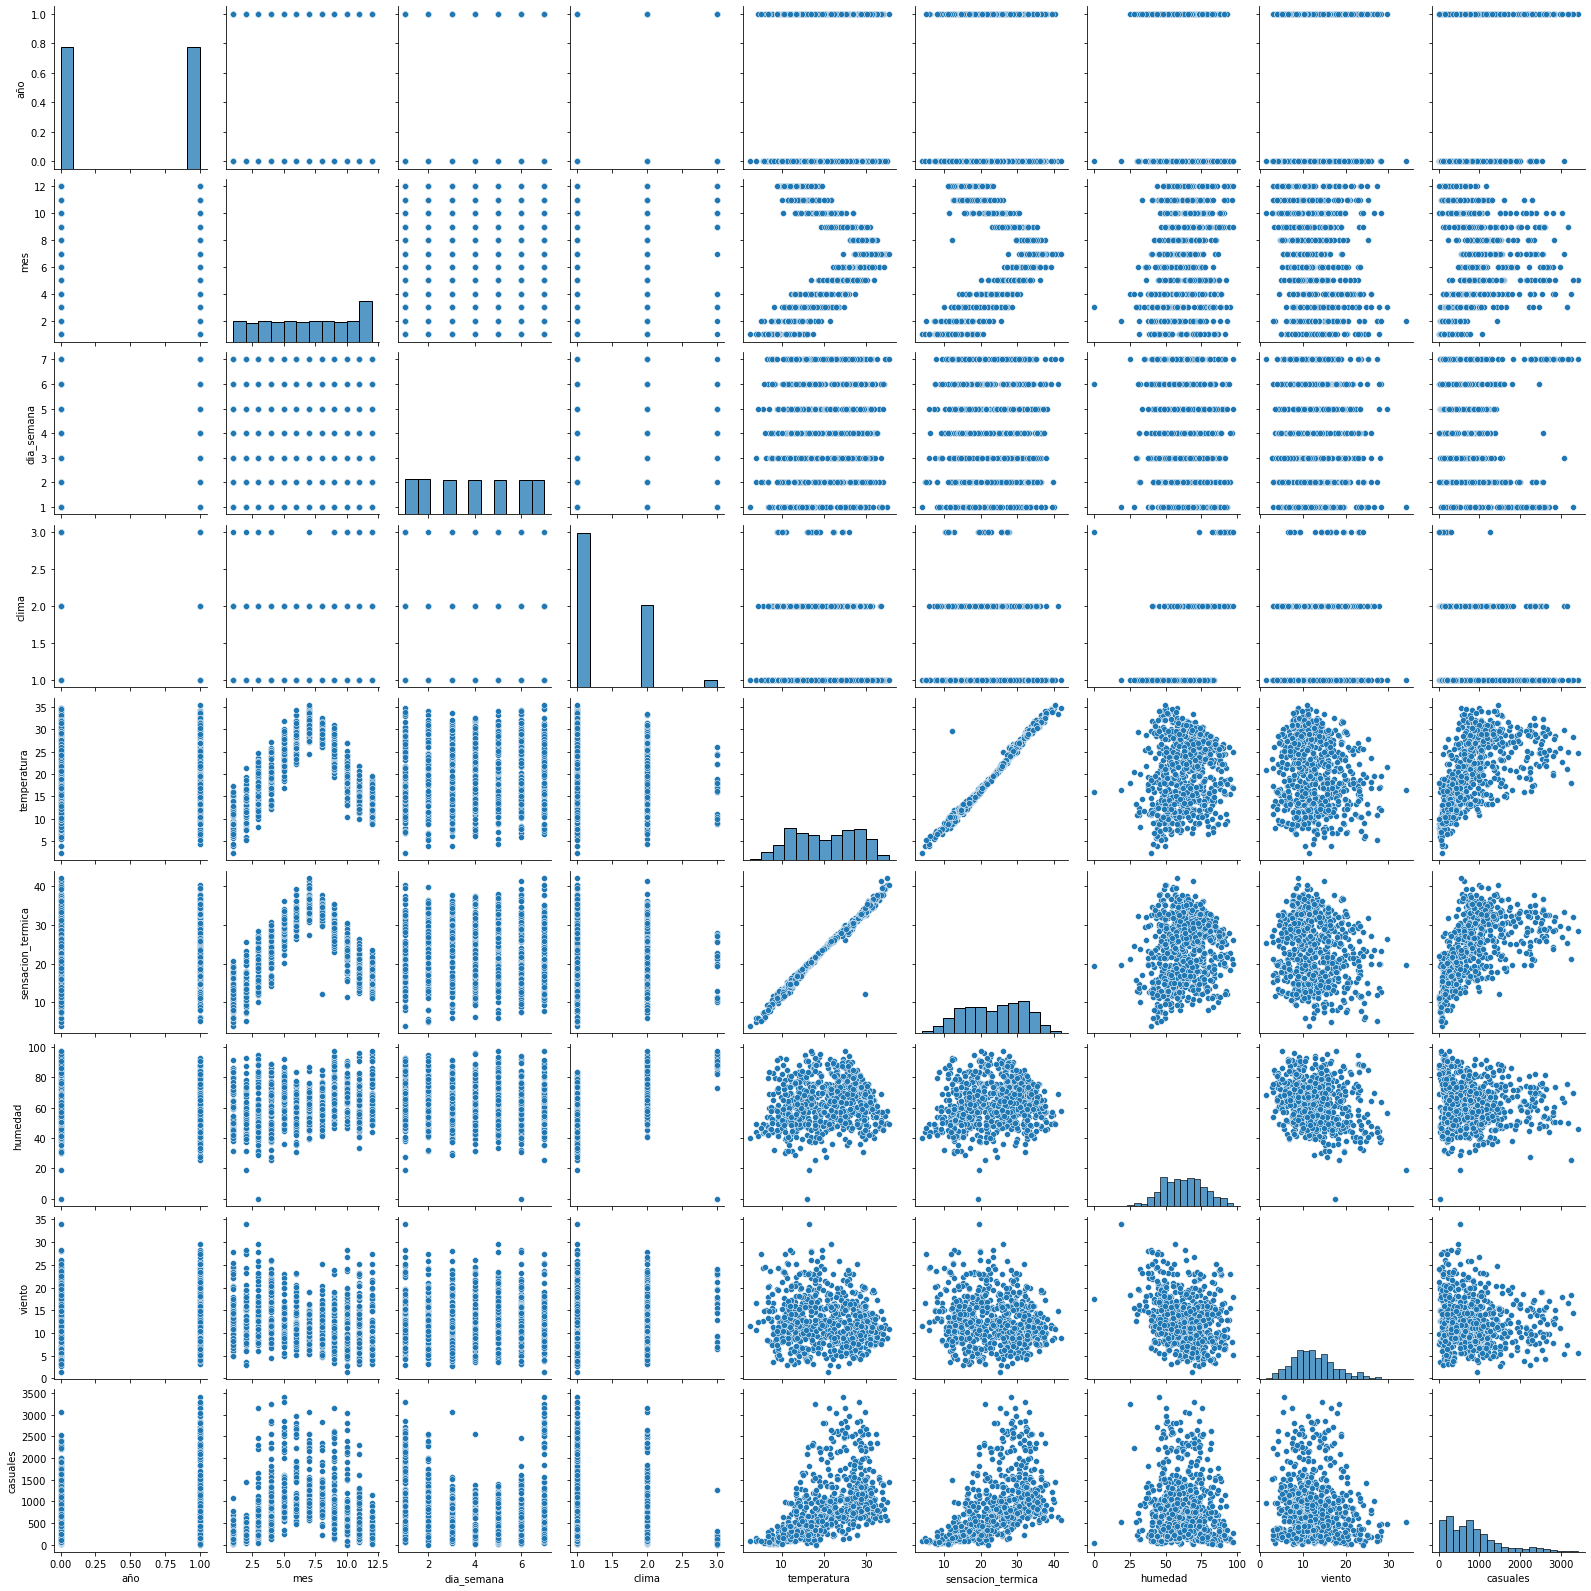

In [40]:
sns.pairplot(df )

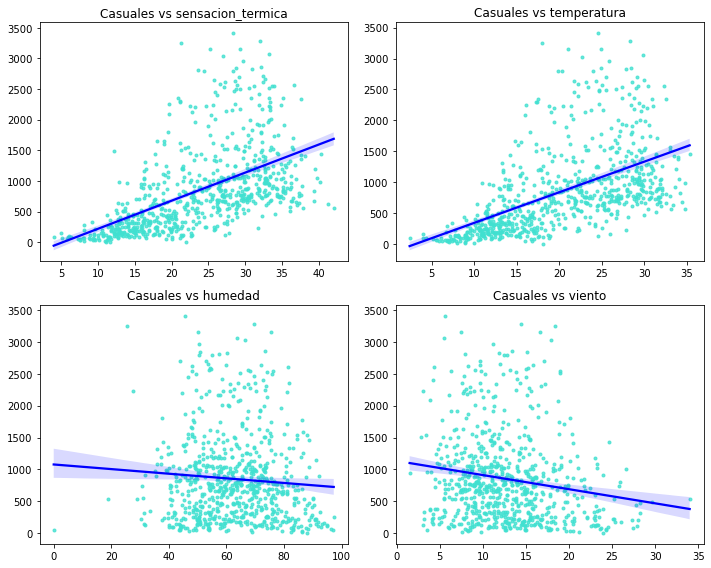

In [43]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 8))
axes = axes.flat
lista_columnas = ['sensacion_termica', 'temperatura', 'humedad', 'viento']
for i, colum in enumerate(lista_columnas):
    sns.regplot(
        x = df[colum],
        y = df["casuales"],
        color = "turquoise",
        marker = ".",
        scatter_kws = {"alpha": 0.8},
        line_kws = {"color": "blue", "alpha": 1 },
        ax = axes[i])
    axes[i].set_title(f"Casuales vs {colum}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
fig.tight_layout();

In [44]:
#Variables que no nos aportan para nuestro modelo o que son redundantes, eliminamos
df.drop(["temperatura"], axis = 1, inplace = True)

In [45]:
#Comprobamos los cambios hechos
df.head()

,fecha,estacion,año,mes,vacaciones,dia_semana,laborable,clima,sensacion_termica,humedad,viento,casuales
0,2018-01-01,winter,0,1,1,1,NO,2,18.18125,80.5833,10.749882,331
1,2018-01-02,winter,0,1,0,2,SI,2,17.68695,69.6087,16.652113,131
2,2018-01-03,winter,0,1,0,3,SI,1,9.47025,43.7273,16.636703,120
3,2018-01-04,winter,0,1,0,4,SI,1,10.60610,59.0435,10.739832,108
4,2018-01-05,winter,0,1,0,5,SI,1,11.46350,43.6957,12.522300,82


In [46]:
df.to_csv("../data/02_casuales_limpio.csv")